# Creating crosslinked polymers with SwiftPol

Note: This is an experimental capability and will become integrated into SwiftPol's build module soon.

This code uses SwiftPol's framework to build a chain of Polyethylene Glycol Diacrylate (PEGDA) and build a large crosslinked polymer network with a degree of crosslinking controlled by function input.

<b>Lukasz Sekula, 2025<b>

In [2]:
# Imports
from rdkit import Chem
from rdkit.Chem import AllChem
import random

from swiftpol import build

In [3]:
def build_starting_polymer(sequence='ABBBBBBBBBA', 
                           monomers=["IC=CC(=O)OI", "IOCCOI"], 
                           polymer_reaction=AllChem.ReactionFromSmarts("[C:1]-[O:2]-[I:3].[C:4]-[O:5]-[I:6]>>[C:1]-[O:2]-[C:4].[I:3]-[I:6].[O:5]"), 
                           activation_reaction=AllChem.ReactionFromSmarts('[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]')):
    """
    Builds a polymer and adds reactive sites.

    Parameters:
        - sequence (str): Polymer sequence
        - monomers (list): List of monomers (SMILES format)
        - polymer_reaction (rdkit reaction): Reaction to form the polymer
        - activation_reaction (rdkit reaction): Reaction to introduce reactive sites

    Returns:
        - starting_polymer (rdkit Mol): PEGDA polymer with reactive sites
    """
    #Build PEGDA polymer
    polymer = build.build_polymer(sequence=sequence, monomer_list=monomers, reaction=polymer_reaction)

    activatorCl = Chem.MolFromSmiles('Cl')
    activatorI = Chem.MolFromSmiles('I')

    # Apply activation reaction twice
    starting_polymer = activation_reaction.RunReactants([polymer, activatorCl, activatorI])[0][0]
    Chem.SanitizeMol(starting_polymer)

    starting_polymer = activation_reaction.RunReactants([starting_polymer, activatorCl, activatorI])[0][0]
    Chem.SanitizeMol(starting_polymer)

    Chem.AddHs(starting_polymer)
    return starting_polymer

starting_polymer = build_starting_polymer()

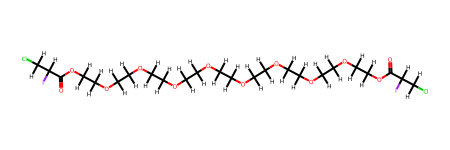

In [7]:
# Let's take a look at PEGDA, with it's labelled crosslinking sites
starting_polymer

In [8]:
# Define a function to remove halogen markers once we have build oue crosslinked network
def replace_halogens_with_hydrogens(mol):
    """Replaces all halogen atoms (F, Cl, Br, I) with hydrogen atoms."""
    editable = Chem.RWMol(mol)   #Creates an editable version of an RDKit molecule
    halogen_atomic_nums = [9, 17, 35, 53]  #F, Cl, Br, I

    for atom in list(editable.GetAtoms()):  #list() to avoid issues
        if atom.GetAtomicNum() in halogen_atomic_nums:
            idx = atom.GetIdx()
            #Remove the halogen
            editable.RemoveAtom(idx)

    #Sanitize and add hydrogens back
    mol_no_halogens = editable.GetMol()
    mol_no_halogens.UpdatePropertyCache()
    Chem.SanitizeMol(mol_no_halogens)

    #Add explicit hydrogens
    mol_with_h = Chem.AddHs(mol_no_halogens)
    return mol_with_h


In [9]:
# Define the reaction parameters
activatorF = Chem.MolFromSmiles('F')
activatorBr = Chem.MolFromSmiles('Br')

reaction_templates = [
    ('[Cl:1]-[C:2]-[C:3](-[I:4])-[C:5](=[O:6])-[O:7].[Cl:8]-[C:9]-[C:10](-[I:11])-[C:12](=[O:13])-[O:14].[F:15].[F:16]>>[O:14]-[C:12](=[O:13])-[C:10](-[F:15])-[C:9]-[C:2]-[C:3](-[F:16])-[C:5](=[O:6])-[O:7].[Cl:1].[I:4].[Cl:8].[I:11]', (activatorF, activatorF)),
    ('[O:1]-[C:2](=[O:3])-[C:4](-[F:5])-[C:6]-[C:7]-[C:8](-[F:9])-[C:10](=[O:11])-[O:12].[Cl:13]-[C:14]-[C:15](-[I:16])-[C:17](=[O:18])-[O:19].[Br:20]>>[O:1]-[C:2](=[O:3])-[C:4](-[Br:20])-[C:6]-[C:7]-[C:8](-[C:14]-[C:15](-[I:16])-[C:17](=[O:18])-[O:19])-[C:10](=[O:11])-[O:12].[Cl:1].[F:9].[F:5]', (activatorBr,)),
    ('[O:1]-[C:2](=[O:3])-[C:4](-[Br:5])-[C:6]-[C:7]-[C:8](-[C:9](=[O:10])-[O:11])-[C:12]-[C:13](-[I:14])-[C:15](=[O:16])-[O:17].[Cl:18]-[C:19]-[C:20](-[I:21])-[C:22](=[O:23])-[O:24]>>[O:1]-[C:2](=[O:3])-[C:4](-[C:19]-[C:20](-[I:21])-[C:22](=[O:23])-[O:24])-[C:6]-[C:7]-[C:8](-[C:9](=[O:10])-[O:11])-[C:12]-[C:13](-[I:14])-[C:15](=[O:16])-[O:17].[Br:5].[Cl:18]', ()),
    ('[O:1]-[C:2](=[O:3])-[C:4](-[F:5])-[C:6]-[C:7]-[C:8](-[F:9])-[C:10](=[O:11])-[O:12].[O:13]-[C:14](=[O:15])-[C:16](-[F:17])-[C:18]-[C:19]-[C:20](-[F:21])-[C:22](=[O:23])-[O:24]>>[O:1]-[C:2](=[O:3])-[C:4](-[C:16](-[C:14](=[O:15])-[O:13])(-[C:18]-[C:19]-[C:20](-[F:21])-[C:22](=[O:23])-[O:24]))-[C:6]-[C:7]-[C:8](-[F:9])-[C:10](=[O:11])-[O:12].[F:5]-[F:17]', ()),
]

# Convert SMARTS strings into RDKit reactions
chain_reactions = [(AllChem.ReactionFromSmarts(smarts), reactants) for smarts, reactants in reaction_templates]
crosslink_reactions = [(AllChem.ReactionFromSmarts(smarts), reactants) for smarts, reactants in reaction_templates]  #Same reactions, different reactants


probability_of_linear_addition = 0.5
probability_of_crosslinked_addition = 0.5

def build_crosslinked_polymer(starting_polymer, 
                              num_iterations=1, 
                              probability_of_crosslinked_addition=0.5, 
                              probability_of_linear_addition=0.5):
    """Applies reactions to the same polymer, adding chains or crosslinking it."""
    # Check if the probabilities sum to 1
    if probability_of_crosslinked_addition + probability_of_linear_addition != 1:
        raise AssertionError("Probabilities must sum to 1.") # Raises error if assertation fails
    
    polymer_network = starting_polymer  # This is the main polymer we modify
    polymer_history = [polymer_network]  # Stores each iteration of the polymer network

    successful_reactions = 0
    while successful_reactions < num_iterations:
        # Choose whether to add a chain or crosslink
        action = random.choices(["add_chain", "crosslink"], weights=[probability_of_linear_addition, probability_of_crosslinked_addition], k=1)[0]

        if action == "crosslink":
            # Ensure crosslinking only happens when there's something to crosslink with
            if len(polymer_history) < 2:
                continue  # Skip this step and retry

            # Choose a previous polymer to crosslink with
            chosen_polymer = random.choice(polymer_history[:-1])  # Select from earlier polymer versions
            chosen_reaction, chosen_reactants = random.choices(crosslink_reactions, weights=[0.0,0.0,0.5,0.5], k=1)[0]
            reactant_sequence = (polymer_network, chosen_polymer) + chosen_reactants  # Use current and chosen polymer

        else:  # Adding a chain
            chosen_reaction, chosen_reactants = random.choices(chain_reactions, weights=[1.0,0.0,0.0,0.0], k=1)[0]
            reactant_sequence = (polymer_network, starting_polymer) + chosen_reactants  # Add chain to current polymer

        # Apply the reaction
        reactant_sets = chosen_reaction.RunReactants(reactant_sequence)

        if not reactant_sets:
            continue  # Retry without counting this attempt

        # Choose one of the successful products
        polymer_network = random.choice(reactant_sets)[0]
        polymer_history.append(polymer_network)  # Save the new polymer version
        successful_reactions += 1  # Count successful reactions

    return replace_halogens_with_hydrogens(polymer_history[-1])  # Return last polymer in the history, with halogens removed


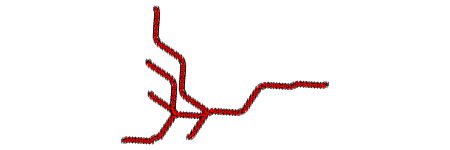

In [10]:
# A crossliked polymer with 50:50 linear to crosslinked ratio
build_crosslinked_polymer(starting_polymer, num_iterations=10, probability_of_crosslinked_addition=0.5, probability_of_linear_addition=0.5)

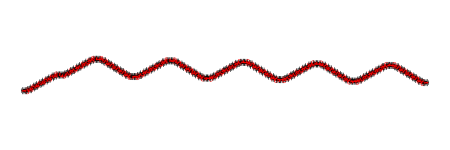

In [11]:
# A polymer with 0% crosslinked chains
build_crosslinked_polymer(starting_polymer, num_iterations=10, probability_of_crosslinked_addition=0, probability_of_linear_addition=1.0)

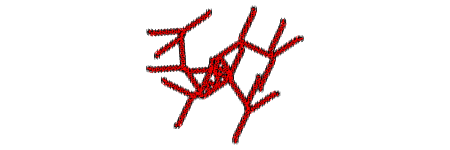

In [12]:
# A polymer with 20:80 crosslinked to linear ratio
build_crosslinked_polymer(starting_polymer, num_iterations=10, probability_of_crosslinked_addition=0.8, probability_of_linear_addition=0.2)